# Exploratory Data Analysis, Preprocessing and Training

In [1]:
# Importing necessary libraries
import os
import sys
import glob
import warnings
warnings.filterwarnings("ignore")
from itertools import product
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2B0, preprocess_input
from tensorflow.keras.layers import Input, Reshape, Conv2D, Conv2DTranspose, AveragePooling2D, GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU, ReLU, Rescaling
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Setting random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

Environment Assessment:

In [2]:
# Checking environment versions and GPU availability with CUDA
print(f"Python Version: {sys.version}")
print(f"TensorFlow Version: {tf.__version__}")
print("GPUs:", tf.config.list_physical_devices("GPU"))
print("CUDA:", tf.test.is_built_with_cuda())
!nvcc --version

Python Version: 3.9.21 (main, Dec 11 2024, 16:35:24) [MSC v.1929 64 bit (AMD64)]
TensorFlow Version: 2.10.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA: True
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_22:08:44_Pacific_Standard_Time_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0


### Metadata Exploratory Data Analysis and Preprocessing
Outlined in section 3.2.1 - 3.2.3. Additional plots in Appendix A.

Loading in, splitting, exploring and cleaning metadata.

In [3]:
base_skin_dir = "kaggle/data/skin-cancer-mnist-ham10000/" # Setting base directory where images are stored

# Setting paths for different image folders
part_1_path = os.path.join(base_skin_dir, "HAM10000_images_part_1", "*.jpg")
part_2_path = os.path.join(base_skin_dir, "HAM10000_images_part_2", "*.jpg")

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob.glob(part_1_path) + glob.glob(part_2_path)} # Creating one large list of all paths

# Adding image paths and lesion descriptions to dataset
skin_df = pd.read_csv(os.path.join(base_skin_dir, "HAM10000_metadata.csv"))
skin_df["Path"] = skin_df["image_id"].map(imageid_path_dict.get)

del part_1_path, part_2_path # deleting unused attributes, this is done throughout the notebook

# Renaming columns in dataset for readability
skin_df.rename(columns = {
    "lesion_id":"Lesion ID",
    "image_id":"Image ID",
    "dx":"Diagnosis",
    "dx_type":"Diagnosis Method",
    "age":"Age",
    "sex":"Sex",
    "localization":"Localisation",
}, inplace = True)

skin_df["Binary Diagnosis"] = skin_df["Diagnosis"].apply(lambda x: "T" if x == "nv" else "A") # Binary diagnosis shortened name

In [4]:
def splitDataset(df, a, b):
    train_df, temp_df = train_test_split(df, test_size = a, stratify = df["Binary Diagnosis"], random_state = seed) # Creating training and temporary set

    val_df, test_df = train_test_split(temp_df, test_size = b, stratify = temp_df["Binary Diagnosis"], random_state = seed) # Splitting temporary into validation and test
    return train_df, val_df, test_df

# First split: 80% train, 20% temp (val + test)
# Split temp into 50/50 → 10% val, 10% test
skin_df_train, skin_df_val, skin_df_test = splitDataset(skin_df, 0.2, 0.5)

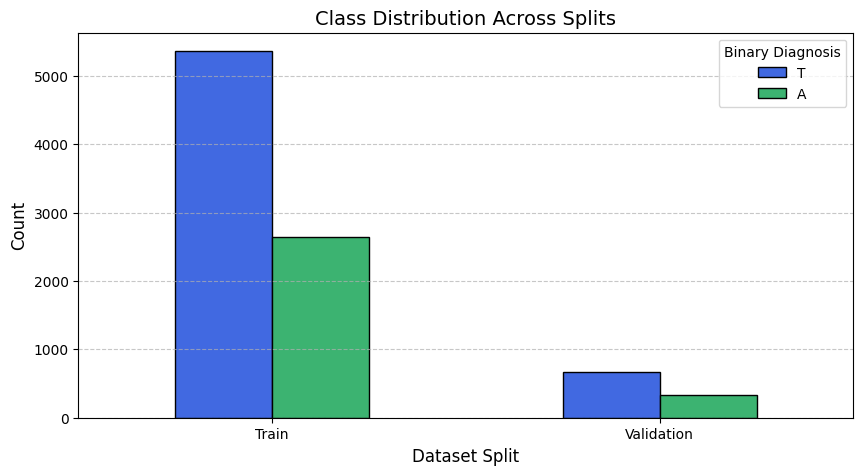

Total training set instances: 8012
Total validation set instances: 1001
Total test set instances: 1002


In [5]:
# Checking training and validation set balance
fig, ax = plt.subplots(figsize=(10, 5))

data = {
    "Train": skin_df_train["Binary Diagnosis"].value_counts(),
    "Validation": skin_df_val["Binary Diagnosis"].value_counts(),
}

dist_df = pd.DataFrame(data)
dist_df.T.plot(kind="bar", ax=ax, color=["royalblue", "mediumseagreen"], edgecolor="black")

# Labelling and adjusting plots
ax.set_title("Class Distribution Across Splits", fontsize=14)
ax.set_xlabel("Dataset Split", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(title="Binary Diagnosis")
plt.show()

print(f"Total training set instances: {len(skin_df_train)}")
print(f"Total validation set instances: {len(skin_df_val)}")
print(f"Total test set instances: {len(skin_df_test)}")

In [6]:
print(skin_df_train.dtypes) # Checking column types
skin_df_train.isnull().sum() # Checking for missing values

Lesion ID            object
Image ID             object
Diagnosis            object
Diagnosis Method     object
Age                 float64
Sex                  object
Localisation         object
Path                 object
Binary Diagnosis     object
dtype: object


Lesion ID            0
Image ID             0
Diagnosis            0
Diagnosis Method     0
Age                 44
Sex                  0
Localisation         0
Path                 0
Binary Diagnosis     0
dtype: int64

In [7]:
skin_df_train.head() # Brief check for dataset structure

,Lesion ID,Image ID,Diagnosis,Diagnosis Method,Age,Sex,Localisation,Path,Binary Diagnosis
6812,HAM_0001342,ISIC_0029366,nv,histo,55.0,female,abdomen,kaggle/data/skin-cancer-mnist-ham10000/HAM1000...,T
8052,HAM_0000897,ISIC_0029306,nv,histo,35.0,female,acral,kaggle/data/skin-cancer-mnist-ham10000/HAM1000...,T
9865,HAM_0005459,ISIC_0032397,akiec,histo,85.0,male,upper extremity,kaggle/data/skin-cancer-mnist-ham10000/HAM1000...,A
9205,HAM_0003946,ISIC_0026991,nv,histo,45.0,female,foot,kaggle/data/skin-cancer-mnist-ham10000/HAM1000...,T
4566,HAM_0001163,ISIC_0028997,nv,follow_up,35.0,female,face,kaggle/data/skin-cancer-mnist-ham10000/HAM1000...,T


In [8]:
# Defining function for applying functions to the training, validation and test sets
def applyFunction(f, train, val, test):
    train = f(train)
    val = f(val)
    test = f(test)
    return train, val, test

# Defining first function for applying age imputation
def imputeAge(df):
    df["Age"].fillna(df["Age"].median(), inplace = True)
    return df

# Filling missing ages with median age
skin_df_train, skin_df_val, skin_df_test = applyFunction(imputeAge, skin_df_train, skin_df_val, skin_df_test)

In [9]:
print(f"Number of images: {len(imageid_path_dict)}") # Displaying total number of images
del imageid_path_dict
print(skin_df_train["Diagnosis"].value_counts(normalize = True)) # Checking training class distribution
print(skin_df_train["Binary Diagnosis"].value_counts(normalize = True)) # Checking training class distribution
print(skin_df_train["Binary Diagnosis"].value_counts(normalize = False)) # Checking training class distribution

Number of images: 10015
Diagnosis
nv       0.669496
mel      0.112332
bkl      0.110459
bcc      0.051173
akiec    0.031328
vasc     0.014353
df       0.010859
Name: proportion, dtype: float64
Binary Diagnosis
T    0.669496
A    0.330504
Name: proportion, dtype: float64
Binary Diagnosis
T    5364
A    2648
Name: count, dtype: int64


In [10]:
# Defining function for creating columns post exploratory data analysis
def createCols(df):
    # Defining dictionary for classes of lesions
    dx_dict = {
        "nv": "Melanocytic Nevi",
        "mel": "Melanoma",
        "bkl": "Benign Keratosis-like Lesions ",
        "bcc": "Basal Cell Carcinoma",
        "akiec": "Actinic Keratoses",
        "vasc": "Vascular Lesions",
        "df": "Dermatofibroma"
    }

    df["Detailed Diagnosis"] = df["Diagnosis"].map(dx_dict.get) # Expanded diagnosis details
    df["Detailed Binary Diagnosis"] = df["Binary Diagnosis"].apply(lambda x: "Typical" if x == "T" else "Atypical") # Binary diagnosis details
    df["Binary Class"] = df["Binary Diagnosis"].apply(lambda x: 0 if x == "T" else 1) # Binary class for labelling
    df["Augmented"] = ["False"] * len(df)
    return df

skin_df_train, skin_df_val, skin_df_test = applyFunction(createCols, skin_df_train, skin_df_val, skin_df_test)

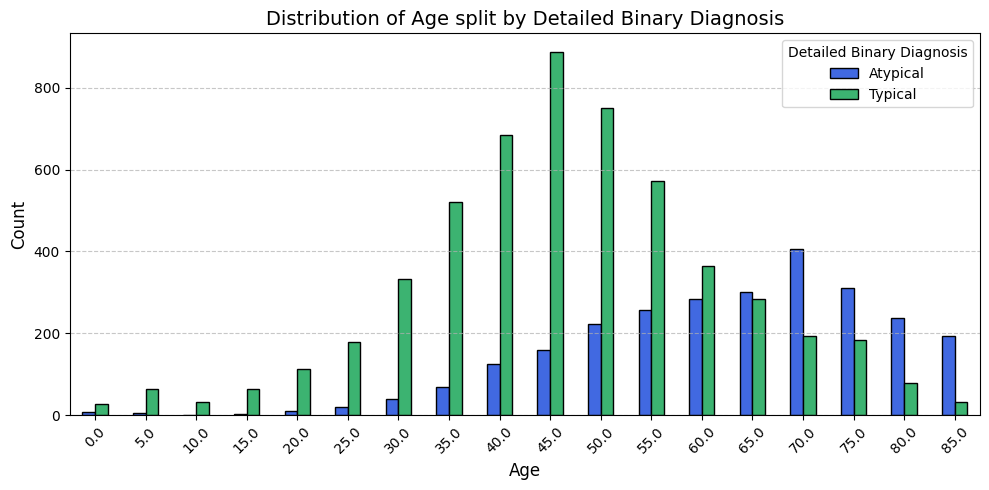

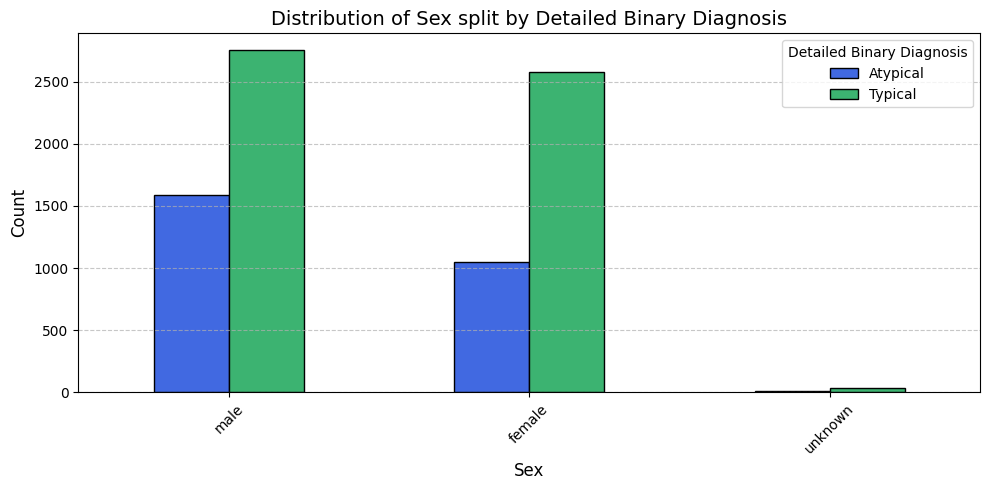

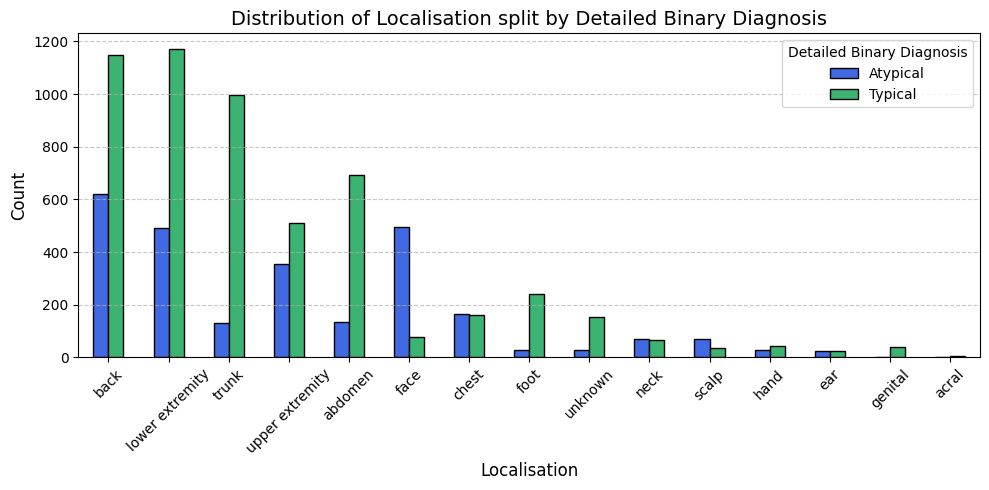

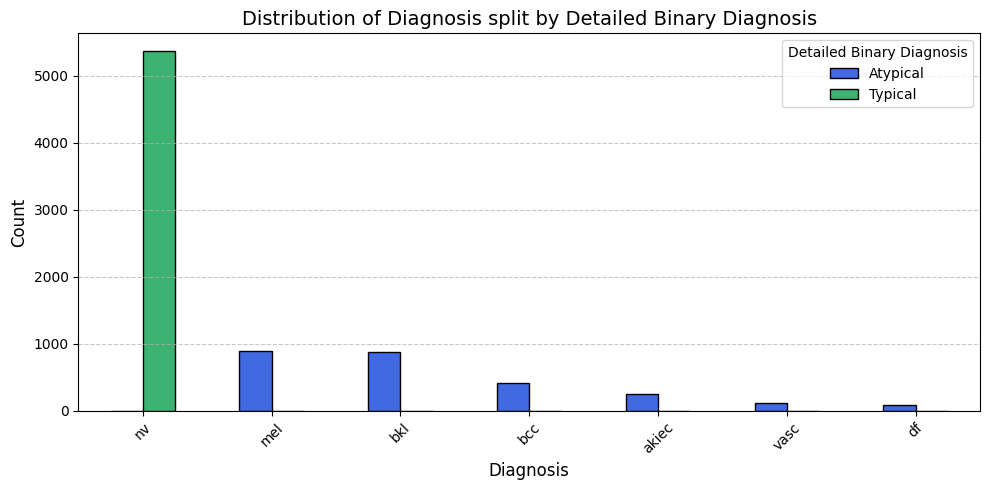

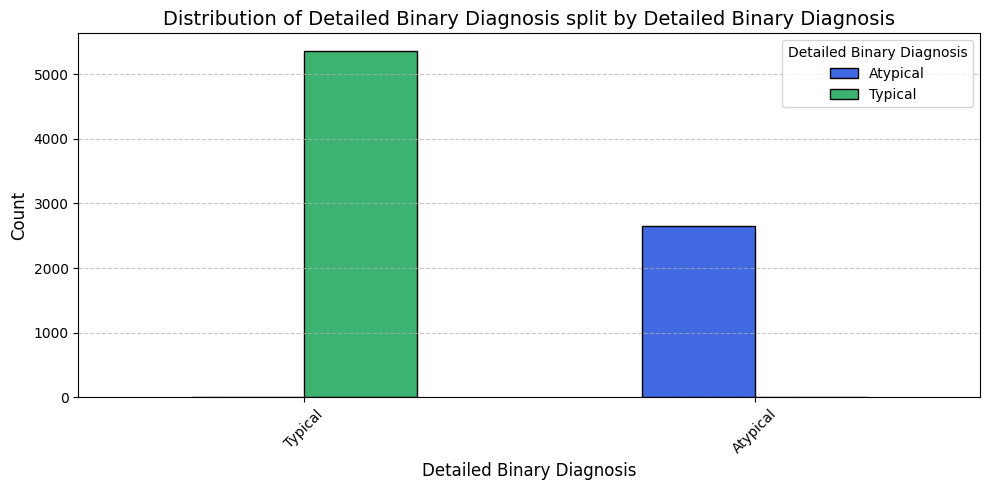

In [13]:
# Defining function for analysis on distribution of columns between classes
def plotDist(df, target, to_group):
    fig, ax = plt.subplots(figsize = (10, 5))

    grouped = df.groupby([target, to_group]).size().unstack() # Creating counts by target and binary class

    # Defining different cases for age and other columns
    if target == "Age":
        grouped = grouped.sort_index() # Sorts by numerical order
    else:
        grouped = grouped.loc[grouped.sum(axis = 1).sort_values(ascending = False).index] # Sorts by frequency

    # Plot grouped bar chart
    grouped.plot(kind = "bar", ax = ax, color = ["royalblue", "mediumseagreen"], edgecolor = "black")

    # Labelling and adjusting plots
    ax.set_title(f"Distribution of {target} split by Detailed Binary Diagnosis", fontsize = 14)
    ax.set_xlabel(target, fontsize = 12)
    ax.set_ylabel("Count", fontsize = 12)
    plt.xticks(rotation = 45)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.7)
    plt.legend(title = "Detailed Binary Diagnosis")
    plt.tight_layout()
    plt.show()

targets = ["Age", "Sex", "Localisation", "Diagnosis", "Detailed Binary Diagnosis"]

to_group = "Detailed Binary Diagnosis"

for target in targets:
    plotDist(skin_df_train, target, to_group)

### Image Loading, Normalisation and Binary Splitting
Outlined in section 3.2.4

Preparing original dataset for learning.

In [19]:
img_size = 128 # Setting image size for resizing and models

# Loading in image data to the training set
def loadImages(df):
    df["Image"] = df["Path"].map(lambda x: np.asarray(Image.open(x).resize((img_size, img_size)))) # Loading and resizing
    return df

skin_df_train, skin_df_val, skin_df_test = applyFunction(loadImages, skin_df_train, skin_df_val, skin_df_test)

In [20]:
# Splitting into features (image data) and labels (one-hot encoding binary class) and normalising
x_train = np.asarray(skin_df_train["Image"].tolist()) / 255
y_train = to_categorical(skin_df_train["Binary Class"], num_classes = 2)

x_val = np.asarray(skin_df_val["Image"].tolist()) / 255
y_val = to_categorical(skin_df_val["Binary Class"], num_classes = 2)

x_test = np.asarray(skin_df_test["Image"].tolist()) / 255
y_test = to_categorical(skin_df_test["Binary Class"], num_classes = 2)

In [21]:
# Saving validation and test data for use in evaluation stage (separate notebook)
skin_df_test.to_csv("skin_df_test.csv", index=False)
np.save("x_val.npy", x_val)
np.save("y_val.npy", y_val)
np.save("x_test.npy", x_test)
np.save("y_test.npy", y_test)

### Building Models
Outlined in section 3.3.2 and 3.3.3

In [34]:
def buildLeNet5():
    model = Sequential([
        Conv2D(6, (5, 5), activation="relu", input_shape = (img_size, img_size, 3)), # Initial convolutional layer for raw inputs
        AveragePooling2D(pool_size = (2, 2)), # Average pooling layer for downsizing

        Conv2D(16, (5, 5), activation="relu"), # Convolutional layer for feature extraction from pooling layer
        AveragePooling2D(pool_size = (2, 2)), # Average pooling layer for downsizing

        Flatten(), # Flattening for pass through to fully connected layers
        Dense(120, activation = "relu"), # Fully connected layers with ReLU activation
        Dropout(0.3), # Dropout for regularisation
        Dense(84, activation = "relu"), # Fully connected layers with ReLU activation
        Dense(2, activation = "softmax") # Classification layer (softmax activation)
    ])

    # Compiling model
    model.compile(
        optimizer = "adam",
        loss = "categorical_crossentropy",
        metrics = ["accuracy", Precision(name="precision"), Recall(name = "recall")]
    )
    return model

# Model summary
buildLeNet5().summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 124, 124, 6)       456       
                                                                 
 average_pooling2d_10 (Avera  (None, 62, 62, 6)        0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 58, 58, 16)        2416      
                                                                 
 average_pooling2d_11 (Avera  (None, 29, 29, 16)       0         
 gePooling2D)                                                    
                                                                 
 flatten_5 (Flatten)         (None, 13456)             0         
                                                                 
 dense_16 (Dense)            (None, 120)              

In [23]:
# Defining model function
def buildEfficientNetV2B0():
    inputs = Input(shape=(img_size, img_size, 3))
    x = Rescaling(255.0)(inputs) # Rescaling input to be processed
    x = preprocess_input(x) # Processing inputs for EfficientNet
    base_model = EfficientNetV2B0(include_top=False, weights="imagenet", input_tensor=x) # Calling base model
    x = GlobalAveragePooling2D()(base_model.output) # Global average pooling to convert feature maps to a single 1D vector per sample
    x = Dropout(0.3)(x) # Dropout for regularisation

    outputs = Dense(2, activation="softmax")(x) # Classification layer (softmax activation)

    model = Model(inputs, outputs) # Building model

    # Compiling model
    model.compile(
        optimizer=Adam(),
        loss="categorical_crossentropy",
        metrics=["accuracy", Precision(name="precision"), Recall(name="recall")]
    )
    return model

# Model summary
buildEfficientNetV2B0().summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 128, 128, 3)  0           ['rescaling[0][0]']              
                                                                                                  
 normalization (Normalization)  (None, 128, 128, 3)  0           ['rescaling_1[0][0]']        

**IMPORTANT: The next cell determines which network is used for the remainder of the code and training (the notebook needs separate runs for each model to obtain all results from this point)**

In [24]:
use_model = "LeNet5"
#use_model = "EfficientNetV2B0"

if use_model == "LeNet5":
    normal_model = buildLeNet5()
    manual_model = buildLeNet5()
    gs_model = buildLeNet5()
    gan_model = buildLeNet5()
if use_model == "EfficientNetV2B0":
    normal_model = buildEfficientNetV2B0()
    manual_model = buildEfficientNetV2B0()
    gs_model = buildEfficientNetV2B0()
    gan_model = buildEfficientNetV2B0()

### Manual Setting Augmentation Parameters and Experimentation
Outlined in section 3.4.4

Parameters chosen based off of visual inspection of augmentations to produce realistic images.

In [14]:
# Defining function to show augmented image alongside original based on passed through parameters
def exampleAugmentation(df, augmentor):
    #random_row = df.sample(1).iloc[0] # Selects a random row
    set_row = df.iloc[seed] # Selects a specific row
    row = set_row
    original_image = Image.open(row["Path"])  # Opening image
    print(f"Image Name: {row['Image ID']} - {row['Detailed Diagnosis']} ({row['Detailed Binary Diagnosis']})")

    image_array = np.expand_dims(np.array(original_image), axis = 0)  # Prepare for augmentation
    augmented_image = augmentor.flow(image_array, batch_size = 1)[0].astype(np.uint8)[0]

    # Display the original and augmented image
    fig, axes = plt.subplots(1, 2, figsize = (10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(augmented_image)
    axes[1].set_title("Augmented Image")
    axes[1].axis("off")

    plt.show()

Image Name: ISIC_0033954 - Melanocytic Nevi (Typical)


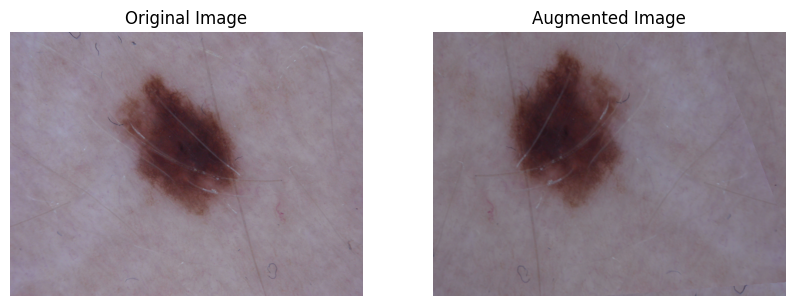

In [17]:
# Good manual set parameters (to be used for generating manual set parameter images with)
good_augmentation = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.15,
    height_shift_range = 0.15,
    brightness_range = (0.8, 1.2),
    shear_range = 25,
    zoom_range = 0.15,
    fill_mode = "wrap",
    horizontal_flip = True
)

exampleAugmentation(skin_df_train, good_augmentation)

Image Name: ISIC_0033954 - Melanocytic Nevi (Typical)


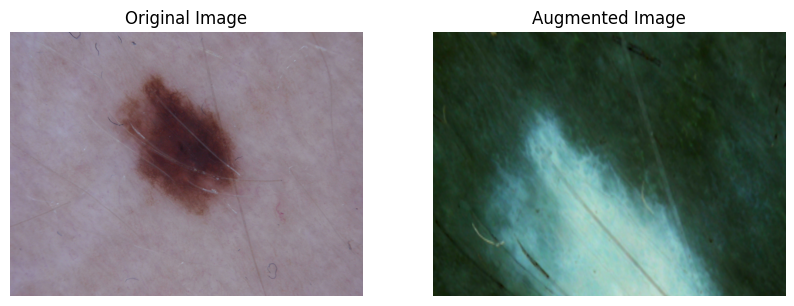

In [18]:
# Bad manual set parameters (not to be used for generating images with)
bad_augmentation = ImageDataGenerator(
    rotation_range = 45,
    width_shift_range = 0.3,
    height_shift_range = 0.3,
    brightness_range = (1.3, 1.6),
    shear_range = 50,
    zoom_range = 0.7,
    fill_mode = "nearest",
    horizontal_flip = True,
    rescale = 255
)

exampleAugmentation(skin_df_train, bad_augmentation)

### Grid Searching for Augmentation Parameters
Outlined in section 3.4.4, results in section 4.1.1

Seperate runs of grid search for parameters are required for different models.

**IMPORTANT: In the next cell change best_params_found to False to start enable searching for the best augmentation parameters for the selected model**

In [25]:
best_params_found = True

In [26]:
# Best data warping parameters found for LeNet5
best_params_LeNet5 = {
    "rotation_range": 30,
    "width_shift_range": 0.2,
    "height_shift_range": 0.2,
    "zoom_range": 0.1,
    "horizontal_flip": True,
    "fill_mode": "reflect"
}

# Best data warping parameters found for EfficientNetV2B0
best_params_EfficientNetV2B0 = {"rotation_range": 20,
                                "width_shift_range": 0.1,
                                "height_shift_range": 0.2,
                                "zoom_range": 0.1,
                                "horizontal_flip": True,
                                "fill_mode": 'reflect'}

In [28]:
# Performing grid search to find best data warping parameters if parameters not found
if best_params_found == False:

    # Initialising parameter grid
    param_grid = {
        "rotation_range": [10, 20, 30],
        "width_shift_range": [0.1, 0.2],
        "height_shift_range": [0.1, 0.2],
        "zoom_range": [0.1, 0.2],
        "horizontal_flip": [True, False],
        "fill_mode": ["reflect"]
    }

    # Creating a list of all possible combinations of augmentation parameters
    combinations = list(product(*param_grid.values()))

    best_accuracy = 0 # Setting base accuracy
    best_params = None # Setting empty best parameters

    for combination in combinations:
        params = dict(zip(param_grid.keys(), combination))
        print(f"Trying parameters: {params}")

        augmentor = ImageDataGenerator(**params) # Defining augmentor from current combination
        train_generator = augmentor.flow(x_train, y_train, batch_size = 32) # Augmenting on the fly

        if use_model == "LeNet5":
            model = buildLeNet5()
        if use_model == "EfficientNetV2B0":
            model = buildEfficientNetV2B0()

        # Training using augmentations from combination
        history = model.fit(
            train_generator,
            validation_data = (x_val, y_val),
            epochs = 10,
            verbose = 0
        )

        # Outputting accuracies
        val_accuracy = history.history["val_accuracy"][-1]
        train_accuracy = history.history["accuracy"][-1]
        print(f"Train accuracy: {train_accuracy:.4f}, Validation accuracy: {val_accuracy:.4f}")

        # Iteratively updating the best parameter combination based on validation accuracy
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    # Displaying best parameters
    best_params_found = True
    print("\nBest augmentation parameters found:")
    print(best_params)
    print(f"Validation accuracy: {best_accuracy:.4f}")
else:
    # Skipping grid search if parameters if already found
    if use_model == "LeNet5":
        best_params = best_params_LeNet5
    if use_model == "EfficientNetV2B0":
        best_params = best_params_EfficientNetV2B0

    print(f"Skipping best grid search augmentation parameter calculation, already found:")
    print(best_params)

Skipping best grid search augmentation parameter calculation, already found:
{'rotation_range': 30, 'width_shift_range': 0.2, 'height_shift_range': 0.2, 'zoom_range': 0.1, 'horizontal_flip': True, 'fill_mode': 'reflect'}


In [29]:
# Exploring balance options
typical_count = (skin_df_train["Binary Diagnosis"] == "T").sum()
atypical_count = (skin_df_train["Binary Diagnosis"] == "A").sum()
print(f"Typical Lesion Count: {typical_count}, Atypical Lesion Count: {atypical_count}")
augmentations_needed = typical_count - atypical_count

print(f"Total augmentations needed for equal typical to atypical: {augmentations_needed}")
print(f"Estimated ~{augmentations_needed/atypical_count} needed per image.")
print(f"Can generate {np.floor(augmentations_needed/atypical_count)} augmented image per image in the atypical class for close balance (data warping): {atypical_count} augmentations")

Typical Lesion Count: 5364, Atypical Lesion Count: 2648
Total augmentations needed for equal typical to atypical: 2716
Estimated ~1.0256797583081572 needed per image.
Can generate 1.0 augmented image per image in the atypical class for close balance (data warping): 2648 augmentations


In [30]:
minority_class = skin_df_train[skin_df_train["Binary Diagnosis"] == "A"] # Defining minority class for augmenting over

### Creating Data Warping Based Augmentations
Outlined in section 3.4.1

Saving images locally for reproducibility and ease of access.

**IMPORTANT: The following two cells determine where paths are saved to and what images we are generating - grid searching for data warping parameters resulted in two optimal combinations between the two models, so we need to generate two different folders worth of images for each of these parameters, as well as one folder worth for the manual set parameters.**

In [31]:
set_dir = "augmented_data_manual"

if use_model == "LeNet5":
    gs_dir = "augmented_data_grid_search_LeNet5"

if use_model == "EfficientNetV2B0":
    gs_dir = "augmented_data_grid_search_EfficientNetV2B0"

In [32]:
#save_dir = set_dir # For generating images from the manual set parameters
save_dir = gs_dir # For generating images from either of the grid search found parameters

os.makedirs(save_dir, exist_ok = True)  # Ensuring folder exists
existing_grid_search_images = glob.glob(os.path.join(save_dir, "*.jpg")) # Checking if folder is empty

In [33]:
# Creating augmented images if folder is empty
if len(existing_grid_search_images) == 0:
    augmentor = ImageDataGenerator(**best_params)

    print("Augmented image folder empty. Generating augmented images.")

    augmented_images = []
    augmentations_needed = typical_count - atypical_count

    for idx, row in minority_class.iterrows():
        img = Image.open(row["Path"]).convert("RGB")  # Ensure RGB format
        img_array = np.expand_dims(np.array(img), axis=0)  # Correctly format for Keras

        aug_iter = augmentor.flow(img_array, batch_size=1)
        aug_img = next(aug_iter)[0].astype(np.uint8)  # Ensure valid pixel values

        img_pil = Image.fromarray(aug_img)  # Convert back to PIL format

        # Use original filename prefixed with "AUG_"
        original_filename = os.path.basename(row["Path"])
        save_path = os.path.join(save_dir, f"AUG_{original_filename}")
        img_pil.save(save_path)

        augmented_images.append(save_path)

    print(f"Generated {len(augmented_images)} new augmented images.")

else:
    print(f"Artificial images already created in {save_dir} - {len(existing_grid_search_images)} images already created.")

Artificial images already created in augmented_data_grid_search_LeNet5 - 2648 images already created.


### Creating Datasets for use with Selected Architecture

Dataset Expanded with Manual Set Parameter Augmentations:

In [55]:
# Creating manual set parameter dataframe
manual_augmented_image_paths = glob.glob(os.path.join(set_dir, "*.jpg")) # Loading paths
manual_augmented_df = pd.DataFrame({
    "Lesion ID": "AUG_" + minority_class["Lesion ID"],
    "Image ID": [os.path.basename(path).split(".")[0] for path in manual_augmented_image_paths],
    "Diagnosis": minority_class["Diagnosis"],
    "Diagnosis Method": minority_class["Diagnosis Method"],
    "Age": minority_class["Age"],
    "Sex": minority_class["Sex"],
    "Localisation": minority_class["Localisation"],
    "Path": manual_augmented_image_paths,
    "Detailed Diagnosis": minority_class["Detailed Diagnosis"],
    "Binary Diagnosis": ["A"] * len(manual_augmented_image_paths),
    "Detailed Binary Diagnosis": minority_class["Detailed Binary Diagnosis"],
    "Binary Class": [1] * len(manual_augmented_image_paths),
    "Augmented": ["True"] * len(manual_augmented_image_paths)
})

del manual_augmented_image_paths

In [56]:
manual_augmented_df["Image"] = manual_augmented_df["Path"].map(lambda x: np.asarray(Image.open(x).resize((img_size, img_size)))) # Loading images

In [57]:
# Preparing manual parameter dataset
skin_df_train_manual_aug = pd.concat([skin_df_train, manual_augmented_df], ignore_index = True)
x_train_manual_aug = np.asarray(skin_df_train_manual_aug["Image"].tolist()) / 255
y_train_manual_aug = to_categorical(skin_df_train_manual_aug["Binary Class"], num_classes = 2)

Dataset Expanded with Grid Search Parameter Found Augmentations:

In [58]:
# Creating grid search parameter dataframe
gs_augmented_image_paths = glob.glob(os.path.join(gs_dir, "*.jpg")) # Loading paths
gs_augmented_df = pd.DataFrame({
    "Lesion ID": "AUG_" + minority_class["Lesion ID"],
    "Image ID": [os.path.basename(path).split(".")[0] for path in gs_augmented_image_paths],
    "Diagnosis": minority_class["Diagnosis"],
    "Diagnosis Method": minority_class["Diagnosis Method"],
    "Age": minority_class["Age"],
    "Sex": minority_class["Sex"],
    "Localisation": minority_class["Localisation"],
    "Path": gs_augmented_image_paths,
    "Detailed Diagnosis": minority_class["Detailed Diagnosis"],
    "Binary Diagnosis": ["A"] * len(gs_augmented_image_paths),
    "Detailed Binary Diagnosis": minority_class["Detailed Binary Diagnosis"],
    "Binary Class": [1] * len(gs_augmented_image_paths),
    "Augmented": ["True"] * len(gs_augmented_image_paths)
})

del gs_augmented_image_paths

In [59]:
gs_augmented_df["Image"] = gs_augmented_df["Path"].map(lambda x: np.asarray(Image.open(x).resize((img_size, img_size))))

In [60]:
skin_df_train_gs_aug = pd.concat([skin_df_train, gs_augmented_df], ignore_index = True)
x_train_gs_aug = np.asarray(skin_df_train_gs_aug["Image"].tolist()) / 255
y_train_gs_aug = to_categorical(skin_df_train_gs_aug["Binary Class"], num_classes = 2)

### Training and Saving DCGAN Networks
Outlined in section 3.4.6, results in section 4.1.2.

Original DCGAN networks adapted from: https://www.kaggle.com/code/ahmednasser2/skin-cancer-gan/notebook

In [35]:
# Setting paths for generator and discriminator models to be saved
generator_path = "HAM10000_Generator.h5"
discriminator_path = "HAM10000_Discriminator.h5"

batch_size = 128 # Same batch size as img_size
z_dim = 128 # Size of the random noise vector, same as img_size

# Defining function which displays images for tracking progress
def showImages(generator, batch_size, z_dim, a, b):
    noise = tf.random.normal([batch_size , z_dim])
    preds = generator(noise, training = False)
    fig, axis = plt.subplots(a, b, figsize=(15, 10))
    for i, ax in enumerate(axis.flat):
        img = preds[i].numpy()
        img = np.clip(img,0,1)
        ax.imshow(img)
        ax.axis("off")
    plt.show()

# Training generator and discriminator models if they do not already exist
if not os.path.exists(generator_path) and not os.path.exists(discriminator_path):
    img_paths = minority_class["Path"].tolist() # Getting paths of all minority class images

    # Setting variables
    epochs = 600 # Deemed appropriate based on output

    # Defining function to load images, convert to tensors and return
    def tensorImage(img_path):
        img = tf.io.read_file(img_path) # Reading in raw image
        img = tf.image.decode_jpeg(img, channels=3) # Transforming into tensor shape
        img = tf.image.resize(img, (img_size, img_size)) # Resizing
        img = tf.cast(img, tf.float32) / 255 # Normalising
        return img

    # Creating dataset of paths and converting to tensors
    dataset = tf.data.Dataset.from_tensor_slices(img_paths)
    dataset = dataset.map(tensorImage)
    dataset = dataset.shuffle(1000).batch(batch_size)

    # Defining discriminator algorithm
    discriminator = Sequential([
        Input(shape = (img_size, img_size, 3)),
        Conv2D(64, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2D(128, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2D(256, kernel_size = 4, strides = 2, padding = "same", use_bias = False) ,
        BatchNormalization(),
        LeakyReLU(0.2),

        Conv2D(512, kernel_size = 4, strides = 2, padding = "same", use_bias = False) ,
        BatchNormalization(),
        LeakyReLU(0.2),

        Flatten(),
        Dense(1, activation = "sigmoid", use_bias = False)
    ])

    # Defining generator algorithm
    generator = Sequential([
        Dense(8*8*512, use_bias=False, input_shape=(z_dim,)),
        BatchNormalization(),
        ReLU(),
        Reshape((8, 8, 512)),

        Conv2DTranspose(256, kernel_size = 4, strides = 2, padding = "same", use_bias = False) ,
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(128, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(64, kernel_size = 4, strides = 2, padding = "same", use_bias = False),
        BatchNormalization(),
        ReLU(),

        Conv2DTranspose(3, kernel_size = 4, strides = 2, padding = "same", activation = "tanh", use_bias = False),
    ])

    # Setting up optimisers and loss functions
    gen_optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5 , beta_2 = 0.999)
    disc_optimizer = Adam(learning_rate = 0.0002, beta_1 = 0.5 , beta_2 = 0.999)
    criterion = BinaryCrossentropy(from_logits = True)

    def discriminatorLoss(real_output, fake_output) :
        real_loss = criterion(tf.ones_like(real_output), real_output)
        fake_loss = criterion(tf.zeros_like(fake_output), fake_output)
        total_loss = real_loss + fake_loss
        return total_loss

    def generatorLoss(fake_output):
        return criterion(tf.ones_like(fake_output), fake_output)

    def trainStep(images):
        noise = tf.random.normal([batch_size, z_dim])
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            fake_images = generator(noise, training = True)

            real_output = discriminator(images, training = True)
            fake_output = discriminator(fake_images, training = True)

            gen_loss = generatorLoss(fake_output)
            disc_loss = discriminatorLoss(real_output, fake_output)

        gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))
        return gen_loss, disc_loss

    disc_losses = []
    gen_losses = []
    for i in tqdm(range(epochs)):
        epoch_disc_loss = []
        epoch_gen_loss = []
        for image  in tqdm(dataset):
            gen_loss, disc_loss = trainStep(image)
            epoch_disc_loss.append(disc_loss)
            epoch_gen_loss.append(gen_loss)
        disc_losses.append(np.mean(epoch_disc_loss))
        gen_losses.append(np.mean(epoch_gen_loss))
        print(f"Epoch : {i+1}, Generator Loss : {gen_losses[-1]}, Discriminator Loss : {disc_losses[-1]}\n")
        if (i+1) % 10 == 0 :
            showImages(generator, batch_size, z_dim, 3, 5)

    generator.save(generator_path)
    discriminator.save(discriminator_path)
else:
    print(f"Generator ({generator_path}) and discriminator ({discriminator_path}) models already exist.")

Generator (HAM10000_Generator.h5) and discriminator (HAM10000_Discriminator.h5) models already exist.


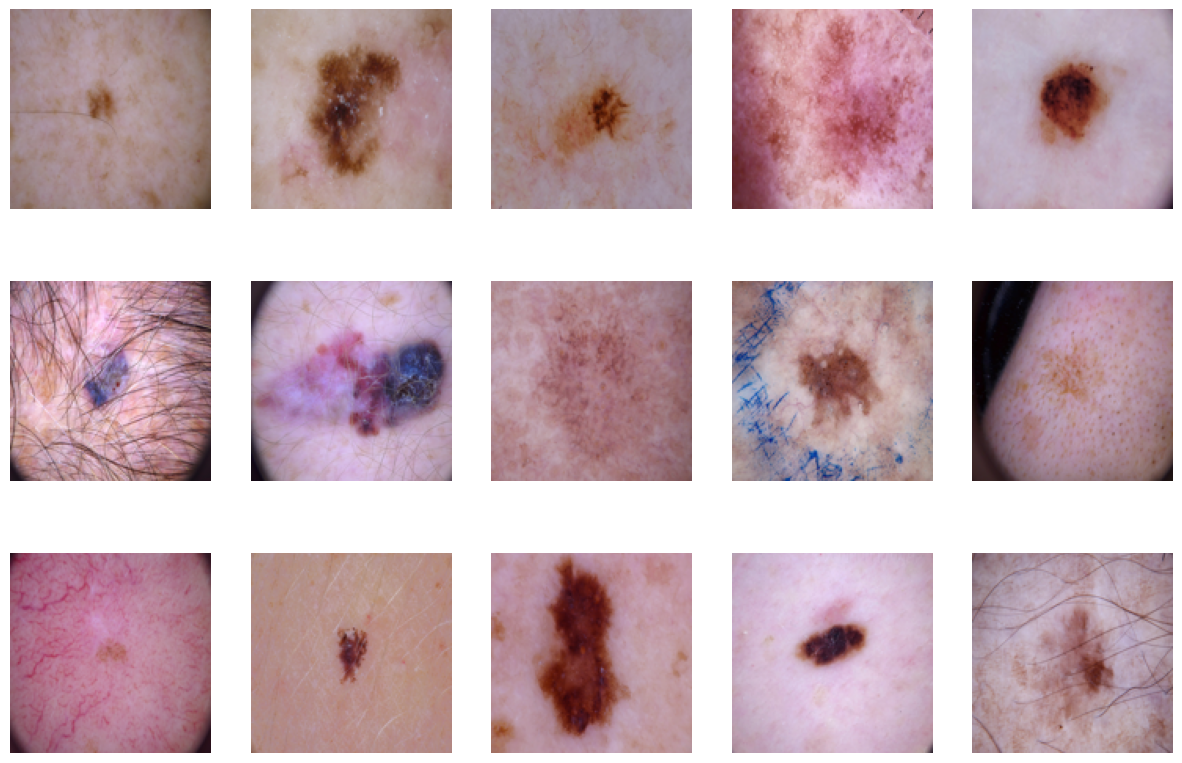

In [55]:
# Displaying examples of resized images
sample_df = minority_class.sample(128)

fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    img = Image.open(sample_df.iloc[i]["Path"]).resize((img_size, img_size)) # Opening and resizing
    ax.imshow(img)
    ax.axis("off")
plt.show()

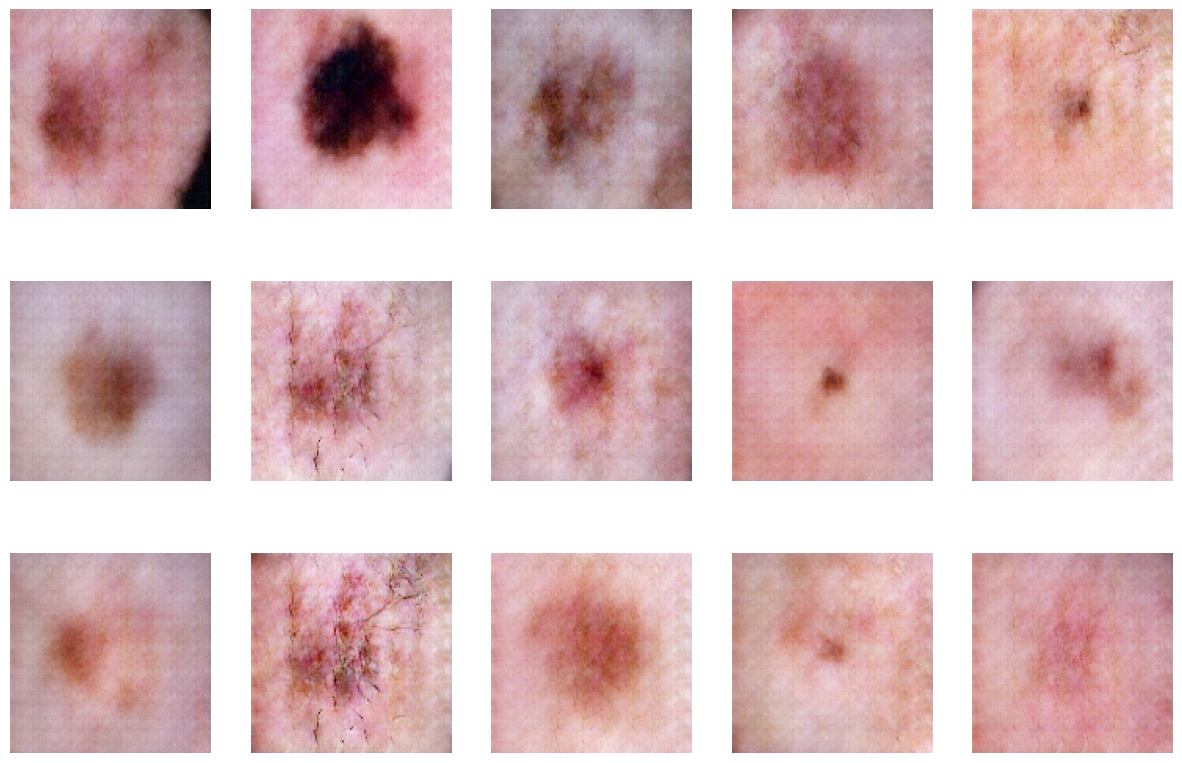

In [70]:
# Displaying examples of GAN generated images
generator = load_model(generator_path)
showImages(generator, batch_size, z_dim, 3, 5)

### Generating Fully Artificial Images Using Trained Generator Model
Outlined in section 3.4.6, results in section 4.1.2.

In [71]:
# Directory to save GAN images
gan_save_dir = "augmented_data_gan"
os.makedirs(gan_save_dir, exist_ok = True)  # Ensure folder exists

existing_gan_images = glob.glob(os.path.join(gan_save_dir, "*.jpg")) # Checking if folder is empty

if len(existing_gan_images) == 0:
    save_dir = "augmented_data_gan"
    num_batches = 21 # Close erfectly balances training dataset (22*128 = 5342)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    image_counter = 0
    for batch in range(num_batches):
        noise = tf.random.normal([batch_size, z_dim]) # Generate a batch of random noise vectors
        preds = generator(noise, training = False) # Generate images (inference mode)

        # Loop over each image in the batch
        for i in range(batch_size):
            # Convert tensor to numpy array and clip values to [0,1]
            img = preds[i].numpy()
            img = np.clip(img, 0, 1)

            filename = os.path.join(save_dir, f'generated_image_{image_counter}.jpg')
            save_img(filename, img)

            image_counter += 1
            print(f"Saved {filename}")
else:
    print(f"GAN images already created. {len(existing_gan_images)} total.")

GAN images already created. 2688 total.


Dataset Expanded with GAN Augmentations:

In [72]:
# LOADING GAN DATASET

gan_augmented_image_paths = glob.glob(os.path.join(gan_save_dir, "*.jpg"))
empty = ["None"] * len(gan_augmented_image_paths)
gan_augmented_df = pd.DataFrame({
    "Lesion ID": empty,
    "Image ID": [os.path.basename(path).split(".")[0] for path in gan_augmented_image_paths],
    "Diagnosis": empty,
    "Diagnosis Method": empty,
    "Age": empty,
    "Sex": empty,
    "Localisation": empty,
    "Path": gan_augmented_image_paths,
    "Detailed Diagnosis": empty,
    "Binary Diagnosis": ["A"] * len(gan_augmented_image_paths),
    "Detailed Binary Diagnosis": ["Atypical"] * len(gan_augmented_image_paths),
    "Binary Class": [1] * len(gan_augmented_image_paths),
    "Augmented": ["True"] * len(gan_augmented_image_paths)
})

del gan_augmented_image_paths

In [73]:
gan_augmented_df["Image"] = gan_augmented_df["Path"].map(lambda x: np.asarray(Image.open(x).resize((img_size, img_size))))

In [74]:
skin_df_train_gan_aug = pd.concat([skin_df_train, gan_augmented_df], ignore_index = True)

x_train_gan_aug = np.asarray(skin_df_train_gan_aug["Image"].tolist()) / 255
y_train_gan_aug = to_categorical(skin_df_train_gan_aug["Binary Class"], num_classes = 2)

### Final Dataset Balance Exploration

In [75]:
print("No Augmentations")
print(skin_df_train["Detailed Binary Diagnosis"].value_counts(normalize = False))
print(skin_df_train["Detailed Binary Diagnosis"].value_counts(normalize = True))
print("Balanced with Manual Augmentations")
print(skin_df_train_manual_aug["Detailed Binary Diagnosis"].value_counts(normalize = False))
print(skin_df_train_manual_aug["Detailed Binary Diagnosis"].value_counts(normalize = True))
print("Balanced with Grid Search Augmentations")
print(skin_df_train_gs_aug["Detailed Binary Diagnosis"].value_counts(normalize = False))
print(skin_df_train_gs_aug["Detailed Binary Diagnosis"].value_counts(normalize = True))
print("Balanced with GAN Augmentations")
print(skin_df_train_gan_aug["Detailed Binary Diagnosis"].value_counts(normalize = False))
print(skin_df_train_gan_aug["Detailed Binary Diagnosis"].value_counts(normalize = True))

No Augmentations
Detailed Binary Diagnosis
Typical     5364
Atypical    2648
Name: count, dtype: int64
Detailed Binary Diagnosis
Typical     0.669496
Atypical    0.330504
Name: proportion, dtype: float64
Balanced with Manual Augmentations
Detailed Binary Diagnosis
Typical     5364
Atypical    5296
Name: count, dtype: int64
Detailed Binary Diagnosis
Typical     0.503189
Atypical    0.496811
Name: proportion, dtype: float64
Balanced with Grid Search Augmentations
Detailed Binary Diagnosis
Typical     5364
Atypical    5296
Name: count, dtype: int64
Detailed Binary Diagnosis
Typical     0.503189
Atypical    0.496811
Name: proportion, dtype: float64
Balanced with GAN Augmentations
Detailed Binary Diagnosis
Typical     5364
Atypical    5336
Name: count, dtype: int64
Detailed Binary Diagnosis
Typical     0.501308
Atypical    0.498692
Name: proportion, dtype: float64


### Model Training
Outlined in section 3.5.1 - 3.5.3

Models implemented with early stopping, callbacks and dropout for regularisation. Leveraging the Adam optimiser with default learning rate (0.001).

Models are saved locally and deleted from memory to improve computational load.

**IMPORTANT: If computational power is not sufficient to store all prepared datasets in memory and train then code can be ran selectively to this point in order to train a specific network with a specific augmentation method**

In [76]:
if use_model == "LeNet5":
    og_model_dir = "best_model_og_LN.keras"
    manual_model_dir = "best_model_manual_aug_LN.keras"
    gs_model_dir = "best_model_gs_aug_LN.keras"
    gan_model_dir = "best_model_gan_aug_LN.keras"
if use_model == "EfficientNetV2B0":
    og_model_dir = "best_model_og_EN.keras"
    manual_model_dir = "best_model_manual_aug_EN.keras"
    gs_model_dir = "best_model_gs_aug_EN.keras"
    gan_model_dir = "best_model_gan_aug_EN.keras"

Training with Original Dataset:

In [ ]:
# Callbacks for training on the original dataset
callbacks_og = [
    EarlyStopping(monitor = "val_loss", patience = 6, verbose = 1, restore_best_weights = True),
    ModelCheckpoint(og_model_dir, monitor = "val_loss", save_best_only = True, verbose = 1)
]

model_og = normal_model
history_og = model_og.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks_og
)

In [39]:
del skin_df_train, model_og, x_train, y_train, callbacks_og

Training with Manual Set Parameter Augmentation Enhanced Dataset:

In [ ]:
# Callbacks for training on the augmented dataset
callbacks_manual_aug = [
    EarlyStopping(monitor = "val_loss", patience = 6, verbose = 1, restore_best_weights = True),
    ModelCheckpoint(manual_model_dir, monitor = "val_loss", save_best_only = True, verbose = 1)
]

model_manual_aug = manual_model
history_manual_aug = model_manual_aug.fit(
    x_train_manual_aug, y_train_manual_aug,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks_manual_aug
)

In [41]:
del skin_df_train_manual_aug, model_manual_aug, x_train_manual_aug, y_train_manual_aug, callbacks_manual_aug

Training with Grid Search Found Parameter Augmentation Enhanced Dataset:

In [ ]:
tf.keras.backend.clear_session()

# Callbacks for training on the augmented dataset
callbacks_gs_aug = [
    EarlyStopping(monitor = "val_loss", patience = 6, verbose = 1, restore_best_weights = True),
    ModelCheckpoint(gs_model_dir, monitor = "val_loss", save_best_only = True, verbose = 1)
]

model_gs_aug = gs_model
history_gs_aug = model_gs_aug.fit(
    x_train_gs_aug, y_train_gs_aug,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks_gs_aug
)

In [46]:
del skin_df_train_gs_aug, model_gs_aug, x_train_gs_aug, y_train_gs_aug, callbacks_gs_aug

Training with DCGAN Enhanced Dataset:

In [ ]:
tf.keras.backend.clear_session()

# Callbacks for training on the augmented dataset
callbacks_gan_aug = [
    EarlyStopping(monitor = "val_loss", patience = 6, verbose = 1, restore_best_weights = True),
    ModelCheckpoint(gan_model_dir, monitor = "val_loss", save_best_only = True, verbose = 1)
]

model_gan_aug = gan_model
history_gan_aug = model_gan_aug.fit(
    x_train_gan_aug, y_train_gan_aug,
    epochs=20,
    validation_data=(x_val, y_val),
    callbacks=callbacks_gan_aug
)

In [56]:
del skin_df_train_gan_aug, model_gan_aug, x_train_gan_aug, y_train_gan_aug, callbacks_gan_aug